# Example of usage Spark OCR for extract metadata from Dicom document

## Install spark-ocr python packge
Need specify:
- license
- path to `spark-ocr-assembly-[version].jar`
- or `secret` for Spark OCR
- `aws_access_key` and `aws_secret_key`for download pretrained models

For more details about Dicom de-identification please read:

 - [DICOM de-identification at scale in Visual NLP — Part 1.](https://medium.com/john-snow-labs/dicom-de-identification-at-scale-in-visual-nlp-part-1-68784177f5f0)

 - [DICOM de-identification at scale in Visual NLP — Part 2.](https://medium.com/john-snow-labs/dicom-de-identification-at-scale-in-visual-nlp-part-2-361af5e36412)

 - [DICOM de-identification at scale in Visual NLP — Part 3.](https://medium.com/john-snow-labs/dicom-de-identification-at-scale-in-visual-nlp-part-3-61cecc3adb56)

In [1]:
license = ""
secret = ""
aws_access_key = ""
aws_secret_key = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../../target/scala-2.12"

## Initialization of spark session

In [2]:
from sparkocr import start
import os
import sys

if license:
    os.environ['JSL_OCR_LICENSE'] = license
    os.environ['SPARK_NLP_LICENSE'] = license

if aws_access_key:
    os.environ['AWS_ACCESS_KEY'] = aws_access_key
    os.environ['AWS_SECRET_ACCESS_KEY'] = aws_secret_key


spark = start(secret=secret,
              jar_path=spark_ocr_jar_path)

spark

Spark version: 3.5.0
Spark NLP version: 6.2.0
Spark NLP for Healthcare version: 6.2.0
Spark OCR version: 6.2.2rc1

:: loading settings :: url = jar:file:/usr/local/lib/python3.11/dist-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-e10f99cf-7c2d-43f8-8e03-dce62f7dc4bc;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;6.2.0 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-s3;1.12.500 in central
	found com.amazonaws#aws-java-sdk-kms;1.12.500 in central
	found com.amazonaws#aws-java-sdk-core;1.12.500 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in central
	found org.apache.httpcomponents#httpcore;4.4.13 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found joda-time#joda-time;2.8.1 in central
	found com.amazonaws#jmespath-java;1.12.500 in central
	found com.g

## Import Spark OCR transformers

In [3]:
import pandas as pd

import sparkocr
from sparkocr.transformers import *
from sparkocr.utils import *
from sparkocr.enums import *
import pyspark.sql.functions as f

from pyspark.ml import PipelineModel, Pipeline

## Define OCR transformers and pipeline

In [4]:
dicom = DicomToMetadata() \
    .setInputCol("content") \
    .setOutputCol("metadata")

## Read dicom objects as binary file and display metadata


In [5]:
import pkg_resources
dicom_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/dicoms')
dicom_df = spark.read.format("binaryFile").option("recursiveFileLookup", "false").load(dicom_path)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

## Compute Stats about dataset

In [6]:
# size in MB
dicom_df.select(f.col("length") / 2**20).summary().show()

+-------+-------------------+
|summary| (length / 1048576)|
+-------+-------------------+
|  count|                  3|
|   mean| 0.6730836232503256|
| stddev|  0.302010905243357|
|    min|0.40700531005859375|
|    25%|0.40700531005859375|
|    50%| 0.6108989715576172|
|    75%| 1.0013465881347656|
|    max| 1.0013465881347656|
+-------+-------------------+



## Show dicom

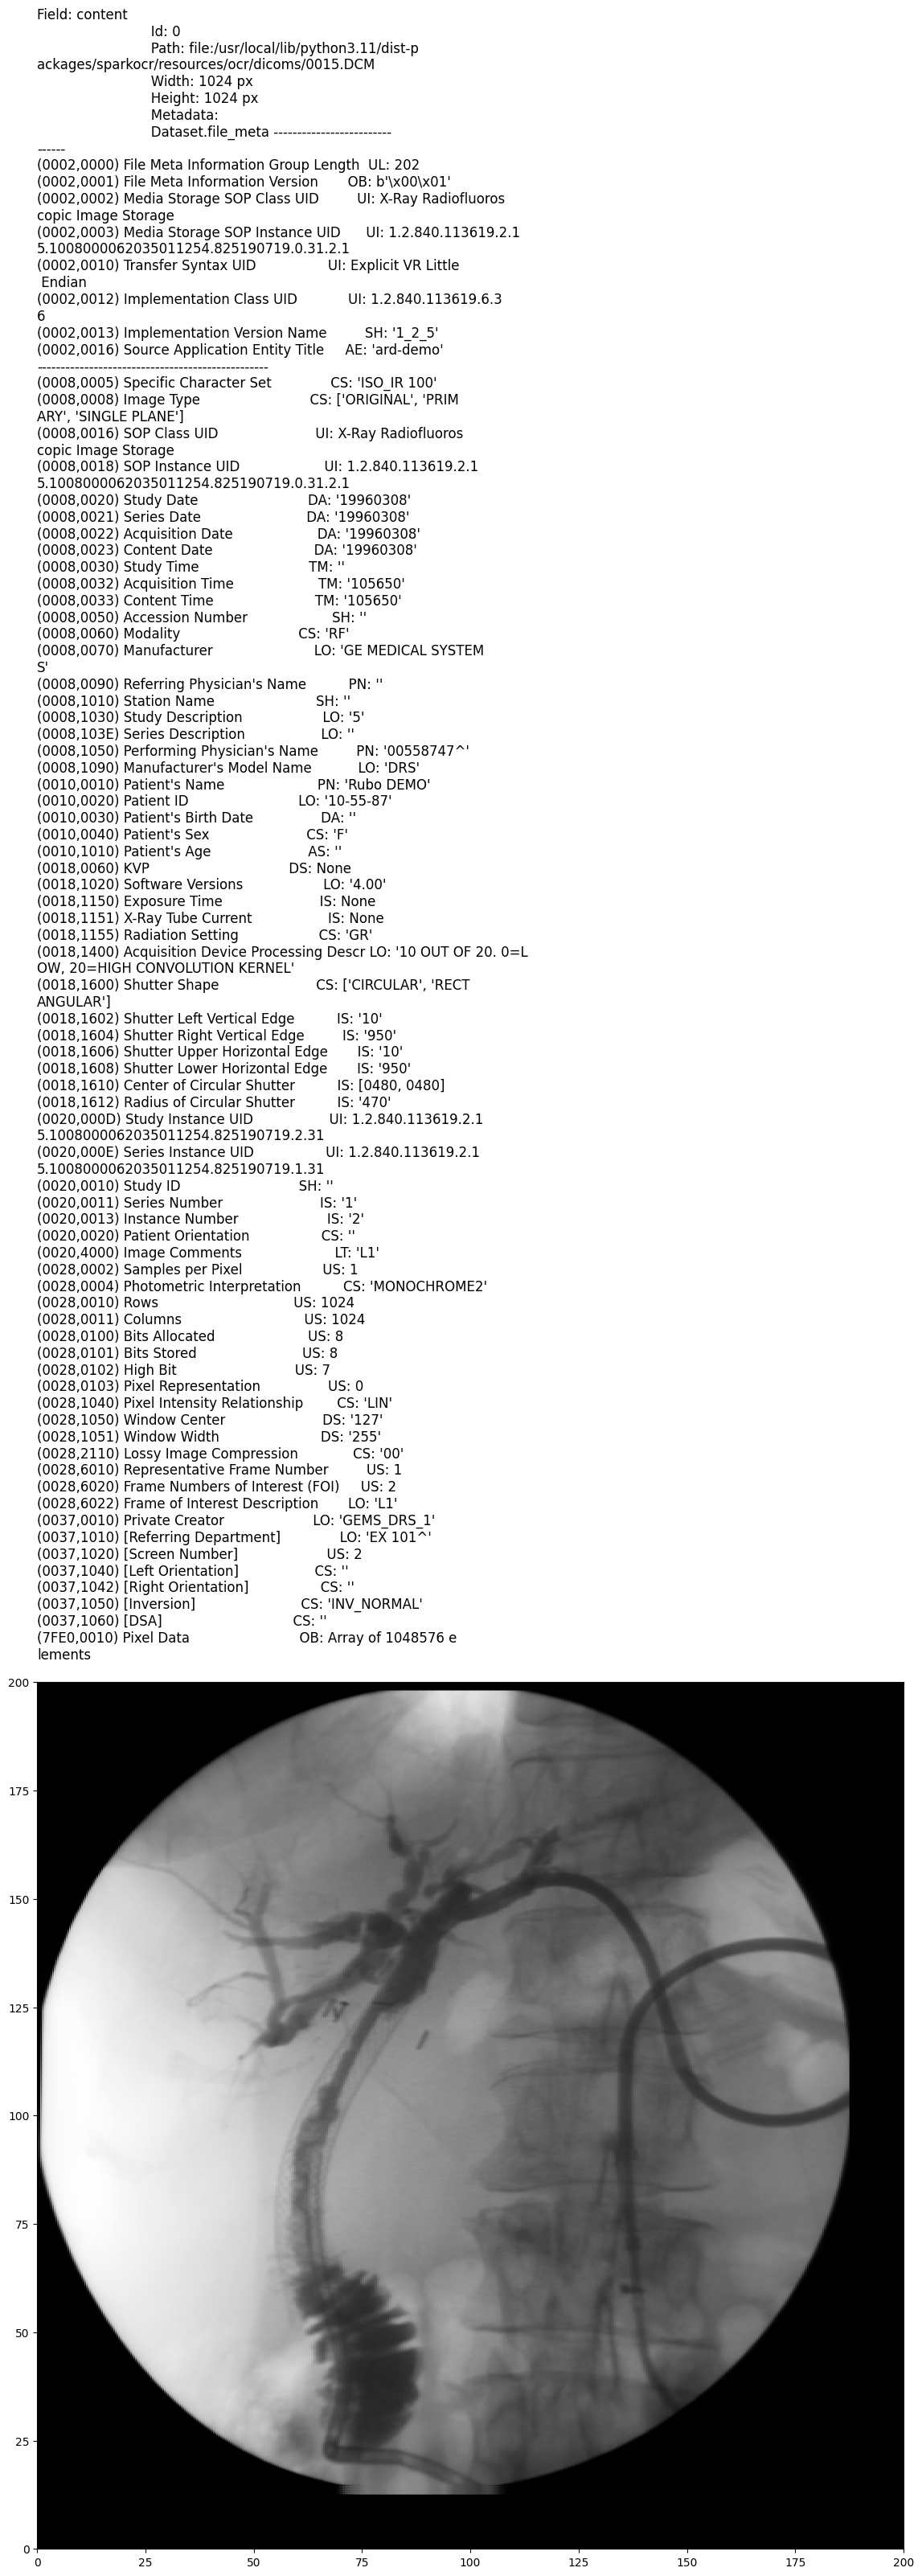

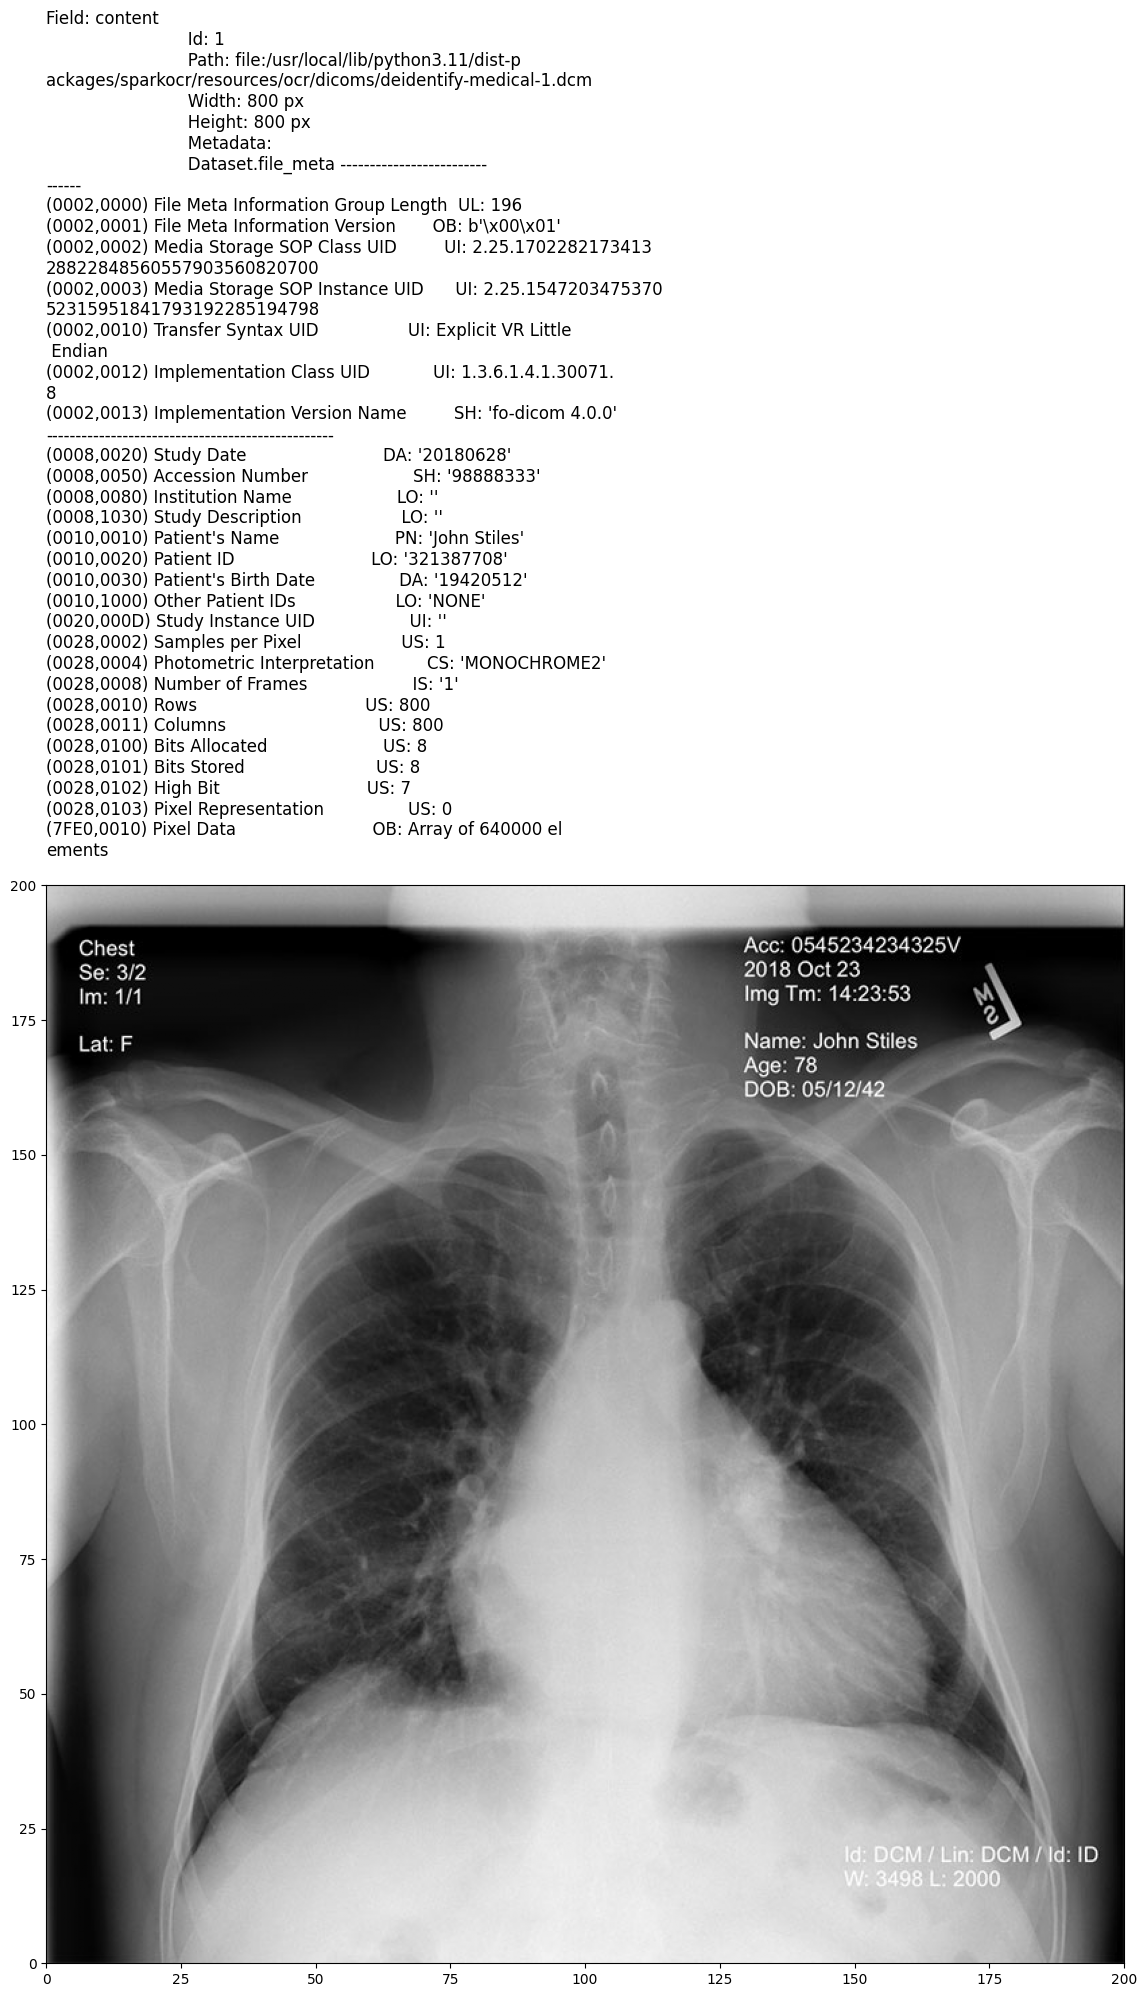

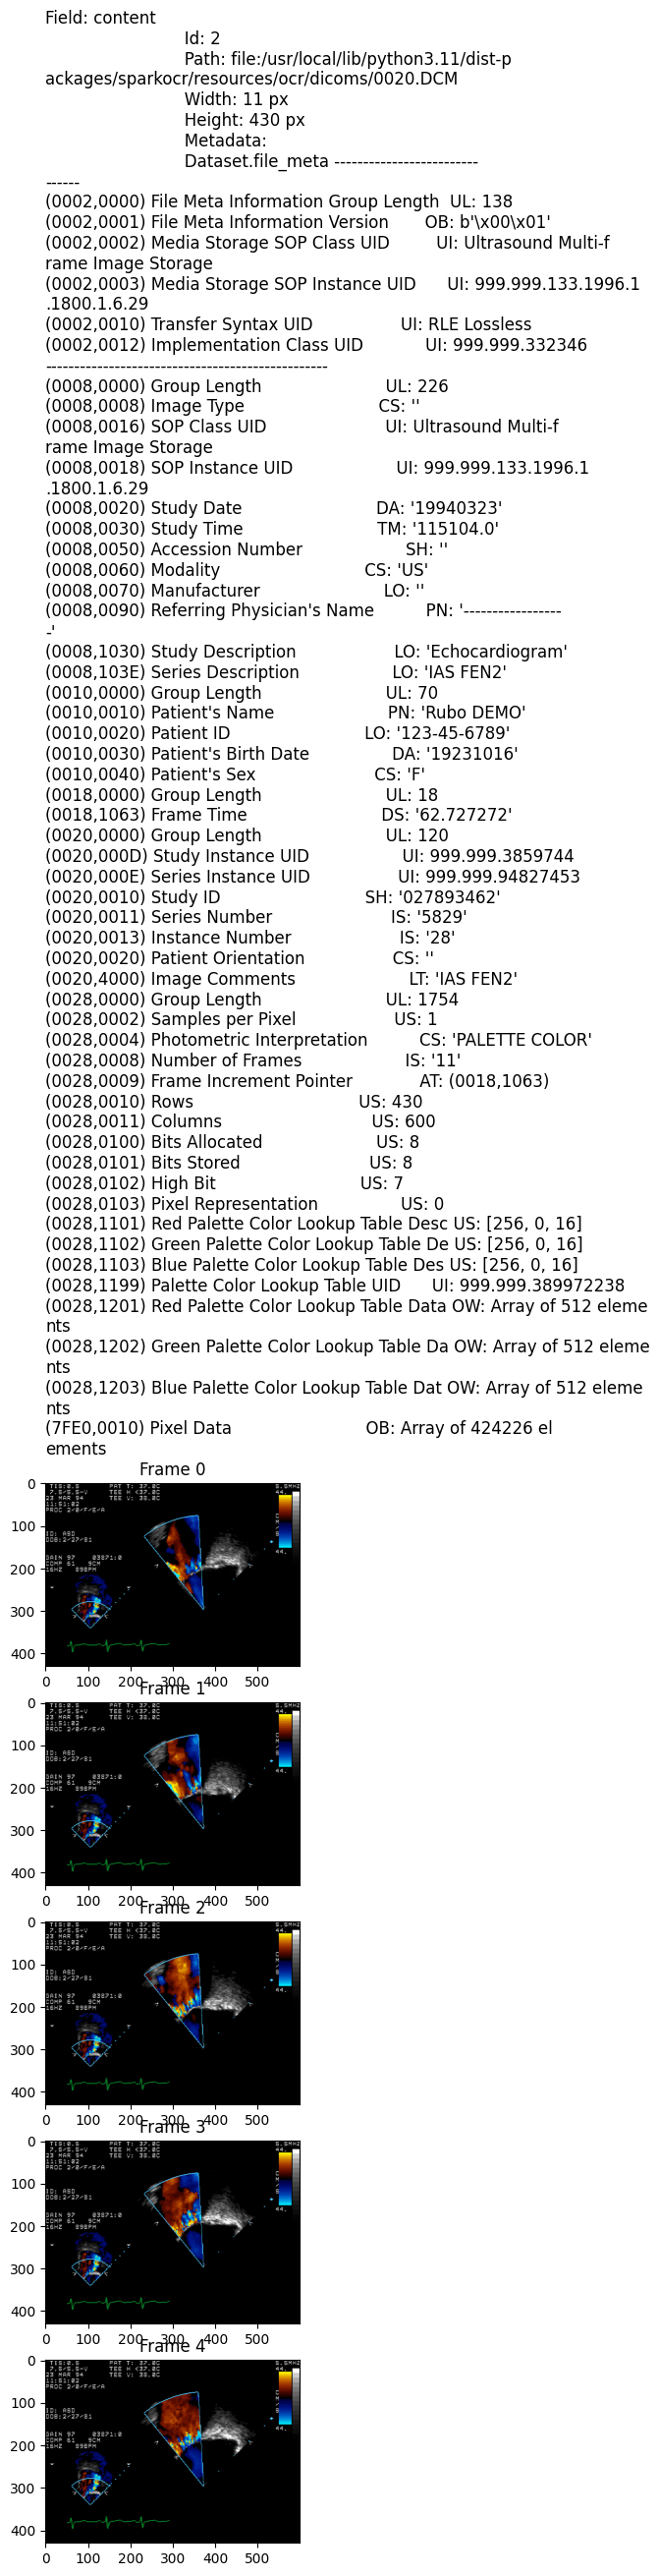

In [7]:
display_dicom(dicom_df, "content")

## Read matadata of dicom document to the dataframe
'metadata' column will contains it as a string

In [8]:
result = dicom.transform(dicom_df)
result

/usr/local/lib/python3.11/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
10:45:10, INFO Run DicomToMetadata                                  (0 + 1) / 1]
10:45:17, INFO DicomToMetadata : Total Rules Extracted 156
10:45:17, INFO DicomToMetadata : Total cleanTag Action Found : 0
10:45:17, INFO DicomToMetadata : Returning Metadata, Document Object and Tag Mapping for NER
10:45:17, INFO Run DicomToMetadata                                              
10:45:17, INFO DicomToMetadata : Total Rules Extracted 156
10:45:17, INFO DicomToMetadata : Total cleanTag Action Found : 0
10:45:17, INFO DicomToMetadata : Returning Metadata, Document Object and Tag Mapping for NER
10:45:21, INFO Run DicomToMetadata====>                             (1 + 1) / 2]
10:45:28, INFO DicomToMetadata : Total Rules Extracted 156
10:45:28, INFO DicomToMetadata : Total cleanT

path,modificationTime,length,exception,metadata,tag_text,tag_mapping
file:/usr/local/l...,2025-12-18 10:26:...,1049988,,"{\n ""00080005""...",Dummy<dicom>,[00000000]
file:/usr/local/l...,2025-12-18 10:26:...,640574,,"{\n ""00080020""...",Dummy<dicom>,[00000000]
file:/usr/local/l...,2025-12-18 10:26:...,426776,,"{\n ""00080000""...",Dummy<dicom>,[00000000]


### Extract Metadata Result

In [9]:
import json 

collect_result = []

for item in result.select("path", "metadata").toLocalIterator():

    data = item.asDict()

    metadata_original = json.loads(data["metadata"])

    for item in metadata_original.keys():
        original_value = str(metadata_original[item]["value"])
        
        
        collect_result.append([data["path"], item, metadata_original[item]["vr"], original_value])

10:45:37, INFO Run DicomToMetadata
10:45:37, INFO DicomToMetadata : Total Rules Extracted 156
10:45:37, INFO DicomToMetadata : Total cleanTag Action Found : 0
10:45:37, INFO DicomToMetadata : Returning Metadata, Document Object and Tag Mapping for NER
10:45:38, INFO Run DicomToMetadata
10:45:38, INFO DicomToMetadata : Total Rules Extracted 156
10:45:38, INFO DicomToMetadata : Total cleanTag Action Found : 0
10:45:38, INFO DicomToMetadata : Returning Metadata, Document Object and Tag Mapping for NER
10:45:38, INFO Run DicomToMetadata
10:45:38, INFO DicomToMetadata : Total Rules Extracted 156
10:45:38, INFO DicomToMetadata : Total cleanTag Action Found : 0
10:45:38, INFO DicomToMetadata : Returning Metadata, Document Object and Tag Mapping for NER


In [10]:
columns = ["File", "Tag", "VR", "Original_Value"]

metadata_df = spark.createDataFrame(collect_result, schema=columns)

metadata_df.show(10, True)

+--------------------+--------+---+--------------------+
|                File|     Tag| VR|      Original_Value|
+--------------------+--------+---+--------------------+
|file:/usr/local/l...|00080005| CS|          ISO_IR 100|
|file:/usr/local/l...|00080008| CS|['ORIGINAL', 'PRI...|
|file:/usr/local/l...|00080016| UI|1.2.840.10008.5.1...|
|file:/usr/local/l...|00080018| UI|1.2.840.113619.2....|
|file:/usr/local/l...|00080020| DA|            19960308|
|file:/usr/local/l...|00080021| DA|            19960308|
|file:/usr/local/l...|00080022| DA|            19960308|
|file:/usr/local/l...|00080023| DA|            19960308|
|file:/usr/local/l...|00080030| TM|                    |
|file:/usr/local/l...|00080032| TM|              105650|
+--------------------+--------+---+--------------------+
only showing top 10 rows



## Let's look to the number of frames per file

In [11]:
metadata_df.filter(f.col("Tag") == "00280008") \
    .select(f.col("Original_Value").alias("NumberOfFrames").cast("int")).na.fill(1).summary()

summary,NumberOfFrames
count,2
mean,6.0
stddev,7.0710678118654755
min,1
25%,1
50%,1
75%,11
max,11


## Get statistic about size (width) of the image in dicom
This can be useful for estimate time/resources needed for process dataset

In [12]:
metadata_df.filter(f.col("Tag") == "00280010") \
    .select(f.col("Original_Value").alias("Rows").cast("int")).summary()

summary,Rows
count,3
mean,751.3333333333334
stddev,299.9755545595896
min,430
25%,430
50%,800
75%,1024
max,1024


## Total number of frames

In [13]:
metadata_df.filter(f.col("Tag") == "00280008") \
    .select(f.col("Original_Value").alias("NumberOfFrames").cast("int")) \
    .agg(f.sum("NumberOfFrames").alias("total_frames")).show()

+------------+
|total_frames|
+------------+
|          12|
+------------+



## Aggregate PhotometricInterpretation

In [14]:
metadata_df.filter(f.col("Tag") == "00280004") \
    .groupBy(f.col("Original_Value").alias("PhotometricInterpretation")) \
    .agg(f.count("*").alias("Count")).show()

+-------------------------+-----+
|PhotometricInterpretation|Count|
+-------------------------+-----+
|              MONOCHROME2|    2|
|            PALETTE COLOR|    1|
+-------------------------+-----+

